In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from ast import literal_eval
import statsmodels.api as sm

- Introduction
- Genres
- Actors
    - Name
    - Genre
    - Nationalities? (need scraping)
- Awards
- Countries & Languages
    - Countries
    - Languages
- Plot summaries
- Conclusion

# Introduction

In [2]:
data = pd.read_csv('data/processed/cmu_movies_augmented.csv')

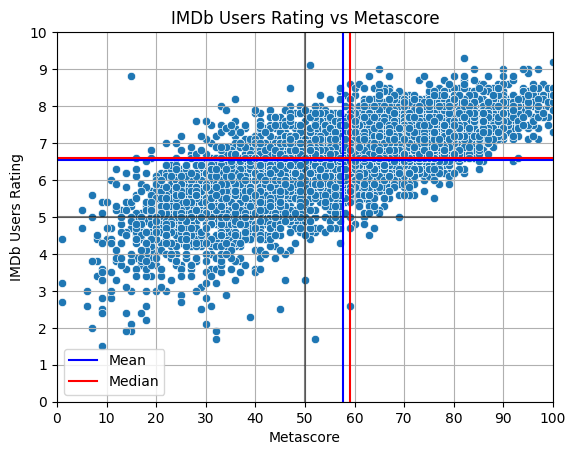

In [3]:
sns.scatterplot(x="metascore", y="imdb_rating", data=data)
plt.title("IMDb Users Rating vs Metascore")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 11, 1))
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.xlabel("Metascore")
plt.ylabel("IMDb Users Rating")
plt.grid()

# plot center lines
plt.axhline(y=5, color='k', linestyle='-', alpha=0.5)
plt.axvline(x=50, color='k', linestyle='-', alpha=0.5)

# plot mean lines
plt.axhline(y=data['imdb_rating'].mean(), color='b', linestyle='-')
plt.axvline(x=data['metascore'].mean(), color='b', linestyle='-')

# plot median lines
plt.axhline(y=data['imdb_rating'].median(), color='r', linestyle='-')
plt.axvline(x=data['metascore'].median(), color='r', linestyle='-')

# legend the lines but not the scatter plots
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
plt.legend(handles=[blue_line, red_line])

plt.show()

In [4]:
data['imdb_rating_scaled'] = data['imdb_rating'] * 10
data['rating_difference'] = data['metascore'] - data['imdb_rating_scaled']

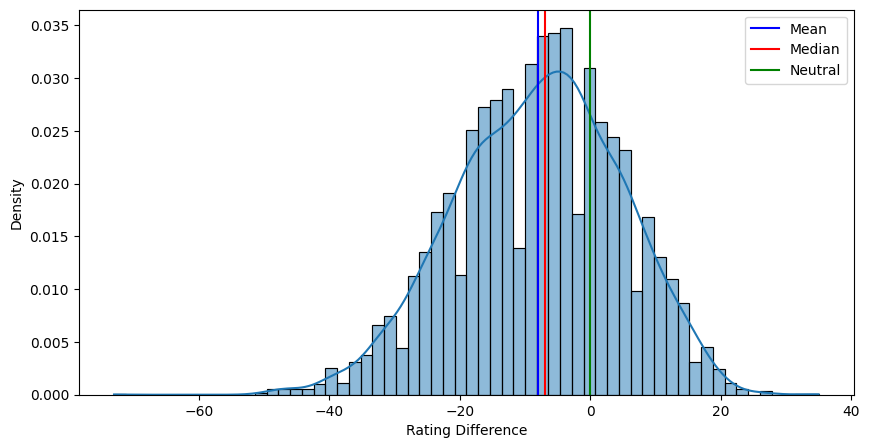

In [5]:
# Plot the mean and median and neutral rating difference
plt.figure(figsize=(10,5))
sns.histplot(data['rating_difference'], kde=True, stat='density', alpha=0.5)
plt.axvline(data['rating_difference'].mean(), color='b')
plt.axvline(data['rating_difference'].median(), color='r')
plt.axvline(0, color='g')
plt.xlabel('Rating Difference')
plt.ylabel('Density')

# Plot legend with corresponding colors
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
green_line = mlines.Line2D([], [], color='green', label='Neutral')
plt.legend(handles=[blue_line, red_line, green_line])

plt.show()

## Genres

In [6]:
# Function to parse the genres column
def parse_genres(genres_str):
    try:
        genres_dict = literal_eval(genres_str)
        return list(genres_dict.values())
    except:
        return []

# Apply the function to the genres column
data['parsed_genres'] = data['genres'].apply(parse_genres)

# Explode the dataset so each genre gets its own row
exploded_genres = data.explode('parsed_genres')

# Group by genre and calculate average rating_difference for each genre
genre_scores = exploded_genres.groupby('parsed_genres')['rating_difference'].mean().reset_index()

# Dropping rows where genre is NaN or Metascore is NaN
genre_scores = genre_scores.dropna()

# Sorting the genres by average rating_difference
genre_scores_sorted = genre_scores.sort_values(by='rating_difference', ascending=False)

# Display the top 10 genres
top_genres = genre_scores_sorted.head(10)
display(top_genres)

# Display the bottom 10 genres
flop_genres = genre_scores_sorted.tail(10)
display(flop_genres)

,parsed_genres,rating_difference
142,Foreign legion,18.000000
285,Star vehicle,16.000000
230,Point of view shot,16.000000
53,Cavalry Film,15.000000
47,British New Wave,15.000000
106,Ealing Comedies,15.000000
271,Silent film,14.545455
241,Propaganda film,9.333333
189,Kitchen sink realism,9.000000
40,Black-and-white,7.275862


,parsed_genres,rating_difference
297,Sword and sorcery,-18.538462
177,Indian Western,-18.666667
296,Sword and Sandal,-19.500000
179,Inspirational Drama,-19.733333
156,Gross-out film,-20.682927
155,Gross out,-20.682927
26,Archaeology,-21.000000
195,Live action,-25.500000
310,Werewolf fiction,-28.000000
220,Ninja movie,-29.000000


### Pearson Correlation

In [7]:
hotencoded_movies_genres = exploded_genres.copy()

# Assuming you have a DataFrame 'exploded_genres'
hotencoded_movies_genres = pd.get_dummies(hotencoded_movies_genres, columns=['parsed_genres'], prefix='onehot')

# Drop rows with missing values in the 'rating_difference' column
hotencoded_movies_genres = hotencoded_movies_genres.dropna(subset=['rating_difference'])

hotencoded_genres_columns = list(filter(lambda x: x.startswith('onehot'), hotencoded_movies_genres.columns))

# Dictionary to store results
correlation_results = {}

# Calculate correlation and p-value for each genre
for col in hotencoded_genres_columns:
    correlation, p_value = pearsonr(hotencoded_movies_genres[col], hotencoded_movies_genres['rating_difference'])
    if not np.isnan(correlation):
        correlation_results[col] = {'correlation': correlation, 'p_value': p_value}

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame.from_dict(correlation_results, orient='index').sort_values(by='correlation', ascending=False)
display(results_df.head(10))
display(results_df.tail(10))


/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,correlation,p_value
onehot_Black-and-white,0.072335,5.951511e-48
onehot_World cinema,0.068733,1.863614e-43
onehot_Drama,0.048222,3.268082e-22
onehot_Art film,0.041031,1.647286e-16
onehot_Film noir,0.033355,2.059786e-11
onehot_New Hollywood,0.032045,1.207552e-10
onehot_Documentary,0.031278,3.295881e-10
onehot_Silent film,0.029439,3.326802e-09
onehot_Biography,0.029031,5.456570e-09
onehot_History,0.027130,5.024387e-08


,correlation,p_value
onehot_Gross-out film,-0.032514,6.459758e-11
onehot_Gross out,-0.032514,6.459758e-11
onehot_Comedy,-0.036683,1.695692e-13
onehot_Horror,-0.036954,1.124715e-13
onehot_Slasher,-0.037697,3.595927e-14
onehot_Thriller,-0.038340,1.317963e-14
onehot_Teen,-0.039775,1.320548e-15
onehot_Slapstick,-0.043711,1.574514e-18
onehot_Action/Adventure,-0.050094,7.611638e-24
onehot_Action,-0.060246,9.069420e-34


### OLS

In [8]:
# Define the independent variables (X) and the dependent variable (y)
X = hotencoded_movies_genres[hotencoded_genres_columns]  # Add all your genre columns here
y = hotencoded_movies_genres['rating_difference']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print out the statistics
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     8.188
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:26:39   Log-Likelihood:            -1.5814e+05
No. Observations:               40350   AIC:                         3.169e+05
Df Residuals:                   40035   BIC:                         3.196e+05
Df Model:                         314                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [9]:
# Find the genres with p-values less than 0.05
significant_genres = []

for row in model_summary.tables[1].data[2:]:
    # convert p-value to float
    if float(row[4]) < 0.05:
        significant_genres.append([row[0], float(row[1]), float(row[4])])

# Convert the list of significant genres to a DataFrame
significant_genres_df = pd.DataFrame(significant_genres, columns=['genre', 'coef', 'p_value'])
significant_genres_df = significant_genres_df.sort_values(by='coef', ascending=False)
display(significant_genres_df)

,genre,coef,p_value
10,onehot_Foreign legion,27.8182,0.029
23,onehot_Star vehicle,25.8182,0.006
18,onehot_Point of view shot,25.8182,0.043
3,onehot_British New Wave,24.8182,0.008
22,onehot_Silent film,24.3636,0.000
20,onehot_Propaganda film,19.1515,0.016
1,onehot_Black-and-white,17.0940,0.000
16,onehot_Mumblecore,16.4848,0.003
21,onehot_Samurai cinema,15.0182,0.005
5,onehot_Essay Film,14.6753,0.013
